<a href="https://colab.research.google.com/github/nv-hiep/GalaxyImageGeneration/blob/main/VAE_GalaxyImageGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**VAE galaxy image generation - GalaxyZoo dataset**

## **Connect to google drive**

In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/google_drive')

Mounted at /content/google_drive


In [ ]:
%cd /content
%pwd
%ls

/content
google_drive/  sample_data/


## **Variational Autoencoder class**

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import keras

from keras.layers import Input,Conv2D,Conv2DTranspose,LeakyReLU,Flatten,Dropout
from keras.layers import Dense,Lambda,BatchNormalization,Reshape,Activation

from keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger

from keras.utils.vis_utils import plot_model
import keras.backend as K

import random

In [ ]:
# Customize loss function -> disable TF eager execution mode.
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [ ]:
# Some parameters
OPTIMIZER=Adam(learning_rate=0.0005)
R_LOSS_FACTOR = 10000
INPUT_DIMS = (128, 128, 3)
EPOCHS = 200
INITIAL_EPOCH = 0
BATCH_SIZE = 32
LATENT_SPACE_SIZE = 200

In [ ]:
DATA_DIR = "/content/google_drive/My Drive/data/galaxy_data"
DATA_PATH = os.path.join("/content/google_drive/My Drive/data/galaxy_data/training/", "trainset")
TEST_PATH = os.path.join("/content/google_drive/My Drive/data/galaxy_data/validation/", "testset")
sample_images_20 = os.listdir(DATA_PATH + '/galaxy')[200 : 240]
print(sample_images_20)

['127934.jpg', '128130.jpg', '128345.jpg', '128434.jpg', '128575.jpg', '129124.jpg', '129187.jpg', '129209.jpg', '129480.jpg', '129501.jpg', '130049.jpg', '130963.jpg', '131221.jpg', '132502.jpg', '132535.jpg', '132639.jpg', '132782.jpg', '132884.jpg', '133100.jpg', '134179.jpg', '134191.jpg', '134231.jpg', '134431.jpg', '135311.jpg', '135337.jpg', '135351.jpg', '136109.jpg', '136937.jpg', '137412.jpg', '137827.jpg', '137862.jpg', '137887.jpg', '138027.jpg', '138539.jpg', '139040.jpg', '139391.jpg', '140211.jpg', '140496.jpg', '142523.jpg', '142803.jpg']


In [ ]:
! pwd

/content


In [ ]:
% cd /content/google_drive/My Drive/data/galaxy_data/validation/testset/galaxies

/content/google_drive/My Drive/data/galaxy_data/validation/testset/galaxies


In [ ]:
% ls | wc -l

871


In [ ]:
% cd /content/google_drive/My Drive/data/galaxy_data/training/
% ls 1_in_between_smooth/ | wc -l

/content/google_drive/My Drive/data/galaxy_data/training
5718


In [ ]:
def save_to_disk(txt_path, values):
    if os.path.isfile(txt_path):
        os.remove(txt_path)
    with open(txt_path, "wb") as fp:   
        pickle.dump(values, fp)
    return

def load_from_disk(txt_path):
    with open(txt_path, "rb") as f:
        values =  pickle.load(f)
    return values

class ReconstructImageCallback(keras.callbacks.Callback):
    def __init__(self, save_path, VAE):
        self.save_path = save_path
        self.VAE = VAE
    
    def on_epoch_end(self, epoch, logs={}):
        # Read an image
        random_id_20 = random.randint(0,39)
        image_path = os.path.join(DATA_PATH, 'galaxy', sample_images_20[random_id_20])
        pil_image = Image.open(image_path)
        pil_image = pil_image.resize((INPUT_DIMS[0],INPUT_DIMS[1]), Image.ANTIALIAS)
        image = np.array(pil_image)/255.

        # Get latent space from Encoder
        latent_space = self.VAE.encoder.predict(np.expand_dims(image,0))

        # Get the reconstructed image from decoder
        reconstructed_image = self.VAE.decoder.predict(latent_space)
        
        # Plot the reconstructed image
        plt.figure()
        plt.imshow(reconstructed_image.squeeze())
        plt.show()

        # Save to file
        plt.imsave(os.path.join(self.save_path, "reconstructed_{}.jpg".format(epoch)),reconstructed_image.squeeze())

## **Create the model**

In [ ]:
class VariationalAutoEncoder(object):
    def __init__(self,
                 input_dims,
                 latent_space_size,
                 encoder_filters,
                 encoder_kernel_size,
                 encoder_strides,
                 encoder_padding,
                 decoder_filters,
                 decoder_kernel_size,
                 decoder_strides,
                 decoder_padding
                 ):
        # params of the VAE model
        self.input_dims = input_dims
        self.latent_space_size = latent_space_size
        self.encoder_filters = encoder_filters
        self.encoder_kernel_size = encoder_kernel_size
        self.encoder_strides = encoder_strides
        self.encoder_padding = encoder_padding
        self.decoder_filters = decoder_filters
        self.decoder_kernel_size = decoder_kernel_size
        self.decoder_strides = decoder_strides
        self.decoder_padding = decoder_padding
        
        # build model
        self._model()
    
    
    def _model(self):
        # Input
        self.images = Input(shape=self.input_dims, name="images")

        # encoder
        encoder_shape_before_flattening = self._encoder()
        
        # decoder
        self.decoder_input = Input(shape=(self.latent_space_size,), name="decoder_input")
        self._create_decoder(encoder_shape_before_flattening)
        
        # create unique model 
        self.model = Model(inputs=self.images, outputs=self.decoder(self.encoder_output))

    
    
    def _encoder(self):
        # create convolutional layers for encoder
        X = self.images
        for i in range(len(self.encoder_filters)):
            X = self._conv_layer(X,
                                 "Conv2D",
                                 self.encoder_filters[i],
                                 self.encoder_kernel_size[i],
                                 self.encoder_strides[i],
                                 self.encoder_padding[i],
                                 "encoder_conv"+str(i)
                                 )
        # keep track of tensor shape before flattening (we will need this to build decoder)
        encoder_shape_before_flattening = K.int_shape(X)[1:]
        
        # flatten the tensor
        X = Flatten()(X)
        
        # create dense layers for mu and sigma
        self.encoder_mu = Dense(units=self.latent_space_size, name='encoder_mu')(X)
        self.encoder_log_var = Dense(units=self.latent_space_size, name='encoder_log_var')(X)
        self.encoder_parameters = Model(self.images, (self.encoder_mu, self.encoder_log_var))
        
        # create encoder output by sampling from normal distribution
        self.encoder_output = Lambda(self.sample_latent_space, name="encoder_output")([self.encoder_mu, self.encoder_log_var])
        self.encoder = Model(inputs=self.images, outputs=self.encoder_output)
        
        return encoder_shape_before_flattening
    
    
    def _create_decoder(self,
                        encoder_shape_before_flattening
                        ):
        X = Dense(np.prod(encoder_shape_before_flattening))(self.decoder_input)
        X = Reshape(encoder_shape_before_flattening)(X)
        
        # create convolutional layers for decoder
        # Upsample the input, use Conv2DTranspose
        for i in range(len(self.decoder_filters)):
            is_not_last_layer = i < len(self.decoder_filters)-1
            X = self._conv_layer(X,
                                 "Conv2DTranspose",
                                 self.decoder_filters[i],
                                 self.decoder_kernel_size[i],
                                 self.decoder_strides[i],
                                 self.decoder_padding[i],
                                 "decoder_conv"+str(i),
                                 batch_norm=is_not_last_layer,
                                 dropout=is_not_last_layer,
                                 activation=is_not_last_layer
                                )
        
        # Sigmoid activation: Output values should be between 0 and 1
        self.decoder_output = Activation("sigmoid")(X)
        self.decoder = Model(inputs=self.decoder_input, outputs=self.decoder_output)

    
    def _conv_layer(self,
                    input,
                    convolution_type,
                    filters,
                    kernel_size,
                    strides,
                    padding,
                    name,
                    batch_norm=True,
                    dropout=True,
                    activation=True
                    ):
        
        # type of keras layer: Conv2D or Conv2DTranspose
        convolution = getattr(keras.layers, convolution_type)
        
        conv_layer = convolution(filters=filters,
                                 kernel_size=kernel_size,
                                 strides=strides,
                                 padding = padding,
                                 name = name
                                 )
        X = conv_layer(input)
        if batch_norm:
            X = BatchNormalization()(X)
        
        if activation:
            X = LeakyReLU()(X)
        
        if dropout:
            X = Dropout(rate=0.25)(X) # any rate you want (0->1)
        
        return X
    
    
    def sample_latent_space(self, mu_and_log_var):
        ''' Latent space'''
        mu, log_var = mu_and_log_var
        normal_samples = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
        return mu + K.exp(log_var / 2) * normal_samples
    
    def compile(self,optimizer, r_loss_factor):
        self.model.compile(optimizer=optimizer,
                           loss=self.penalized_loss(r_loss_factor),
                           metrics=[self.penalized_loss(r_loss_factor)])
    
    
    def penalized_loss(self,r_loss_factor):
        ''' Combination of 2 losses: KL loss and reconstruction loss'''
        def loss(y, y_hat):
            # reconstruction_loss
            r_loss = K.mean(K.square(y-y_hat),axis=[1,2,3]) # dont do mean on batch axis
            
            # KL loss
            kl_loss = -0.5 * K.sum(1 + self.encoder_log_var - K.square(self.encoder_mu) - K.exp(self.encoder_log_var), axis = 1)    
            return r_loss*r_loss_factor + kl_loss
        return loss
    
    
    # Train the model
    def train(self,
              save_path,
              data_flow,
              epochs,
              steps_per_epoch,
              initial_epoch = 0,
              lr_decay = 1,
              learning_rate=0.0005):
        learning_rate_schedule = self.step_decay_schedule(initial_lr=learning_rate, decay_factor=lr_decay, step_size=1)
        history_logger = CSVLogger(os.path.join(save_path, "history.csv"), append=True)
        checkpoint_model = ModelCheckpoint(os.path.join(save_path, "model.h5"), verbose=1)
        checkpoint_weights = ModelCheckpoint(os.path.join(save_path, "weights.h5"), save_weights_only=True, verbose = 1)
        checkpoint_encoder = ModelCheckpoint(os.path.join(save_path, "encoder.h5"), verbose=1)
        checkpoint_encoder.set_model(self.encoder)
        checkpoint_decoder = ModelCheckpoint(os.path.join(save_path, "decoder.h5"), verbose=1)
        checkpoint_decoder.set_model(self.decoder)
        reconstruct_callback = ReconstructImageCallback(os.path.join(save_path, "plots"), self)
        
        history = self.model.fit(
            data_flow,
            shuffle = True,
            epochs = epochs,
            initial_epoch = initial_epoch,
            steps_per_epoch = steps_per_epoch,
            callbacks = [learning_rate_schedule,
                         history_logger,
                         checkpoint_weights,
                         checkpoint_model,
                         checkpoint_encoder,
                         checkpoint_decoder,
                         reconstruct_callback
                         ],
            verbose=1
            )
        return history
    
    def step_decay_schedule(self,initial_lr, decay_factor, step_size):
        def schedule(epoch):
            return initial_lr * (decay_factor ** np.floor(epoch/step_size))
        return LearningRateScheduler(schedule)
    
    
    def load_trained_model(self, load_path, r_loss_factor):
        self.model = load_model(os.path.join(load_path, "model.h5"),
                                custom_objects={
                                    "loss": self.penalized_loss(r_loss_factor),
                                    "sample_latent_space":self.sample_latent_space
                                    }
                                )
        #self.encoder = load_model(os.path.join(load_path, "encoder.h5"), custom_objects={"loss": self.penalized_loss(r_loss_factor),"sample_latent_space":self.sample_latent_space})
        #self.decoder = load_model(os.path.join(load_path, "decoder.h5"), custom_objects={"loss": self.penalized_loss(r_loss_factor),"sample_latent_space":self.sample_latent_space})
    
    def load_trained_weights(self, load_path):
        self.model.load_weights(os.path.join(load_path, "weights.h5"))
    
    def plot_model(self,plots_path):
        plots_path = os.path.join(plots_path, "plots")
        os.makedirs(plots_path, exist_ok=True)
        plot_model(self.model, to_file=os.path.join(plots_path,'model.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.encoder, to_file=os.path.join(plots_path,'encoder.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.decoder, to_file=os.path.join(plots_path,'decoder.png'), show_shapes = True, show_layer_names = True)
        print("Models are ploted in {}".format(plots_path))

In [ ]:
# Model
VAE = VariationalAutoEncoder(
    input_dims=INPUT_DIMS,
    latent_space_size=LATENT_SPACE_SIZE,
    encoder_filters=[32,64,64,64],
    encoder_kernel_size=[3,3,3,3],
    encoder_strides=[2,2,2,2],
    encoder_padding = ["same","same","same","same"],
    decoder_filters=[64,64,32,3],
    decoder_kernel_size=[3,3,3,3],
    decoder_strides=[2,2,2,2],
    decoder_padding=["same","same","same","same"]
    )

print("Encoder and decoder model summary:")
VAE.encoder.summary()
VAE.decoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
Encoder and decoder model summary:
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
encoder_conv0 (Conv2D)          (None, 64, 64, 32)   896         images[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         encoder_conv0[0][0]              
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 32)   0           batch_normalization

In [ ]:
VAE.compile(OPTIMIZER, R_LOSS_FACTOR)
VAE.plot_model(DATA_DIR)

Models are ploted in /content/google_drive/My Drive/data/galaxy_data/plots


## **Train**


### Continue Training

CONTINUE WITH TRAINED WEIGHTS

In [ ]:
# Sometimes, need to continue training using trained weights
# VAE.load_trained_weights(DATA_DIR)
# INITIAL_EPOCH = 0

### Start training

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

file_names = []
for file_name in os.listdir(os.path.join(DATA_PATH, "galaxy")):
    file_names.append(file_name)
DATASET_SIZE = len(file_names)

In [ ]:
print(DATA_PATH)
print(DATASET_SIZE)

/content/google_drive/My Drive/data/galaxy_data/training/trainset
12971


In [ ]:
# create image generator and data flow
data_generator = ImageDataGenerator(rescale=1./255)
data_flow = data_generator.flow_from_directory(
    DATA_PATH,
    target_size = INPUT_DIMS[:2],
    batch_size = BATCH_SIZE,
    shuffle = True,
    class_mode = 'input',
    subset = "training"
    )

Found 12971 images belonging to 1 classes.


In [ ]:
allclasses = data_flow.class_indices    
print('ALL classes:')
print(allclasses)

ALL classes:
{'galaxy': 0}


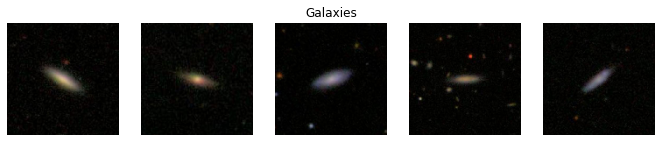

In [ ]:
# Plot some images
from keras_preprocessing import image

plt.figure(figsize=(14,5))
for num, file in enumerate(os.listdir(DATA_PATH+'/galaxy')[0:5]):
    img = image.load_img(os.path.join(DATA_PATH, 'galaxy', file) , target_size=(128, 128))
    plt.subplot(1, 6, num+1)
    
    if num == 2:
      plt.title('Galaxies')
    
    plt.axis('off')
    plt.imshow(img)
plt.show()

In [ ]:
print(DATA_DIR)
print(DATA_PATH)
print(TEST_PATH)

/content/google_drive/My Drive/data/galaxy_data
/content/google_drive/My Drive/data/galaxy_data/training/trainset
/content/google_drive/My Drive/data/galaxy_data/validation/testset


Epoch 161/200
406/405 [==============================] - ETA: -6s - batch: 202.5000 - size: 31.9483 - loss: 19.5974 - loss_1: 19.6040
Epoch 00161: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00161: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00161: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00161: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


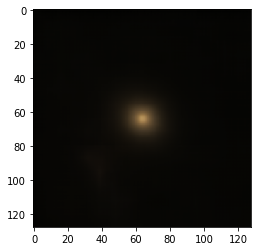

405/405 [==============================] - 3847s 9s/step - batch: 202.5000 - size: 31.9483 - loss: 19.5974 - loss_1: 19.6040 - lr: 5.0000e-04
Epoch 162/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.6126 - loss_1: 19.6078
Epoch 00162: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00162: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00162: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00162: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


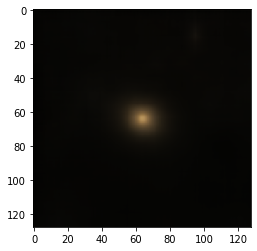

405/405 [==============================] - 353s 871ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.6126 - loss_1: 19.6078 - lr: 5.0000e-04
Epoch 163/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.6325 - loss_1: 19.6292
Epoch 00163: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00163: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00163: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00163: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


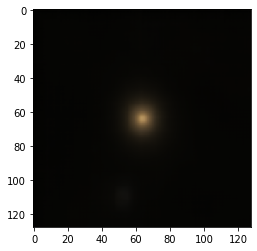

405/405 [==============================] - 351s 867ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.6325 - loss_1: 19.6292 - lr: 5.0000e-04
Epoch 164/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.6608 - loss_1: 19.6578
Epoch 00164: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00164: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00164: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00164: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


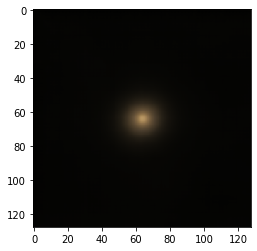

405/405 [==============================] - 359s 885ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.6607 - loss_1: 19.6578 - lr: 5.0000e-04
Epoch 165/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.6456 - loss_1: 19.6360
Epoch 00165: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00165: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00165: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00165: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


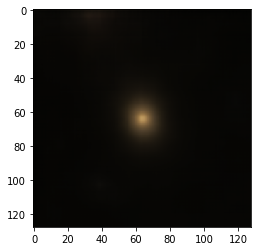

405/405 [==============================] - 357s 881ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.6456 - loss_1: 19.6360 - lr: 5.0000e-04
Epoch 166/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.6500 - loss_1: 19.6600
Epoch 00166: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00166: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00166: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00166: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


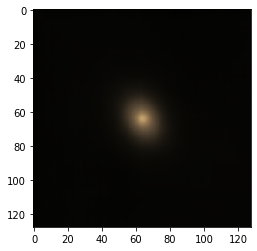

405/405 [==============================] - 358s 883ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.6500 - loss_1: 19.6600 - lr: 5.0000e-04
Epoch 167/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.5873 - loss_1: 19.5836
Epoch 00167: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00167: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00167: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00167: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


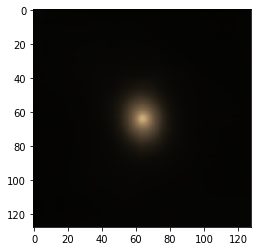

405/405 [==============================] - 359s 885ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.5873 - loss_1: 19.5836 - lr: 5.0000e-04
Epoch 168/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.6172 - loss_1: 19.5982
Epoch 00168: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00168: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00168: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00168: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


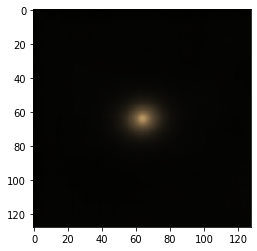

405/405 [==============================] - 359s 886ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.6171 - loss_1: 19.5982 - lr: 5.0000e-04
Epoch 169/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.6081 - loss_1: 19.6085
Epoch 00169: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00169: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00169: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00169: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


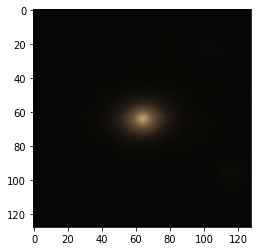

405/405 [==============================] - 360s 887ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.6081 - loss_1: 19.6085 - lr: 5.0000e-04
Epoch 170/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.5979 - loss_1: 19.6065
Epoch 00170: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00170: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00170: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00170: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


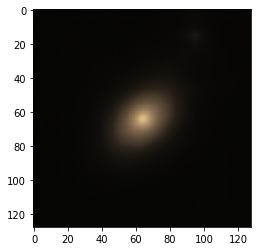

405/405 [==============================] - 364s 899ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.5979 - loss_1: 19.6065 - lr: 5.0000e-04
Epoch 171/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.6017 - loss_1: 19.6009
Epoch 00171: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00171: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00171: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00171: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


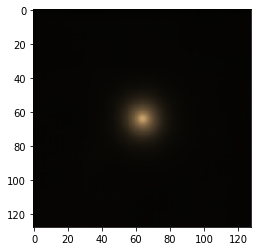

405/405 [==============================] - 363s 895ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.6017 - loss_1: 19.6009 - lr: 5.0000e-04
Epoch 172/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.5744 - loss_1: 19.5808
Epoch 00172: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00172: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00172: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00172: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


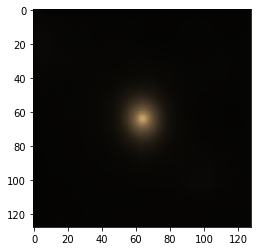

405/405 [==============================] - 364s 899ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.5744 - loss_1: 19.5808 - lr: 5.0000e-04
Epoch 173/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.5884 - loss_1: 19.5940
Epoch 00173: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00173: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00173: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00173: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


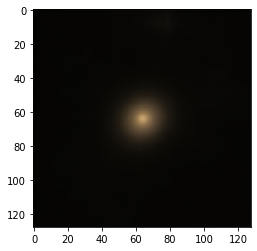

405/405 [==============================] - 362s 893ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.5884 - loss_1: 19.5940 - lr: 5.0000e-04
Epoch 174/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.6093 - loss_1: 19.6024
Epoch 00174: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00174: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00174: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00174: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


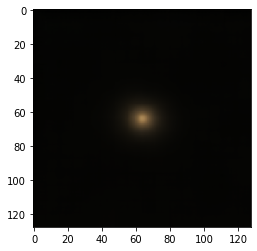

405/405 [==============================] - 362s 893ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.6092 - loss_1: 19.6024 - lr: 5.0000e-04
Epoch 175/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.5719 - loss_1: 19.5594
Epoch 00175: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00175: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00175: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00175: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


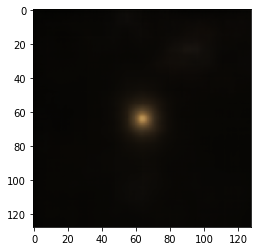

405/405 [==============================] - 363s 894ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.5719 - loss_1: 19.5594 - lr: 5.0000e-04
Epoch 176/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.6171 - loss_1: 19.6111
Epoch 00176: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00176: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00176: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00176: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


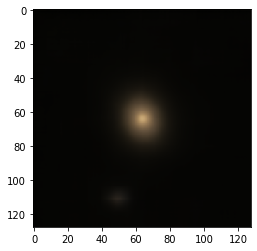

405/405 [==============================] - 364s 899ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.6170 - loss_1: 19.6111 - lr: 5.0000e-04
Epoch 177/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.5822 - loss_1: 19.5810
Epoch 00177: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00177: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00177: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00177: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


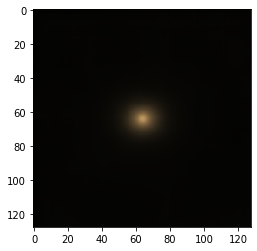

405/405 [==============================] - 363s 896ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.5822 - loss_1: 19.5810 - lr: 5.0000e-04
Epoch 178/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.6007 - loss_1: 19.5841
Epoch 00178: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00178: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00178: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00178: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


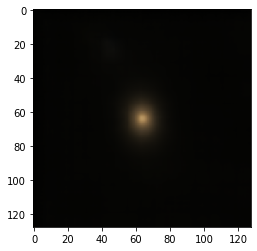

405/405 [==============================] - 362s 894ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.6006 - loss_1: 19.5841 - lr: 5.0000e-04
Epoch 179/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.5646 - loss_1: 19.5611
Epoch 00179: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00179: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00179: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00179: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


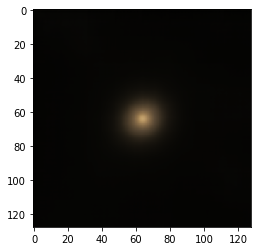

405/405 [==============================] - 363s 895ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.5645 - loss_1: 19.5611 - lr: 5.0000e-04
Epoch 180/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.5613 - loss_1: 19.5679
Epoch 00180: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00180: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00180: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00180: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


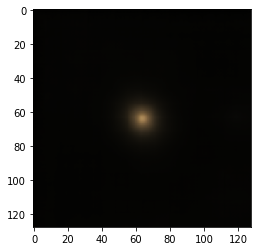

405/405 [==============================] - 367s 906ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.5613 - loss_1: 19.5679 - lr: 5.0000e-04
Epoch 181/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.5335 - loss_1: 19.5420
Epoch 00181: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00181: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00181: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00181: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


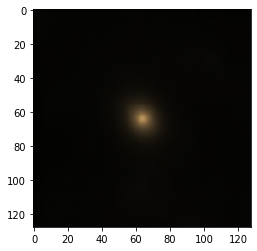

405/405 [==============================] - 366s 904ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.5335 - loss_1: 19.5420 - lr: 5.0000e-04
Epoch 182/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.6041 - loss_1: 19.6017
Epoch 00182: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00182: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00182: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00182: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


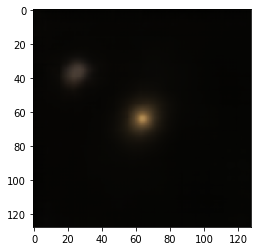

405/405 [==============================] - 365s 900ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.6040 - loss_1: 19.6017 - lr: 5.0000e-04
Epoch 183/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.5967 - loss_1: 19.5978
Epoch 00183: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00183: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00183: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00183: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


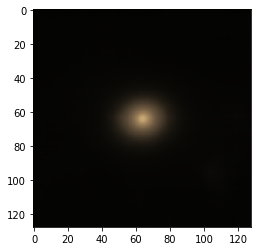

405/405 [==============================] - 364s 898ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.5967 - loss_1: 19.5978 - lr: 5.0000e-04
Epoch 184/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.5692 - loss_1: 19.5629
Epoch 00184: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00184: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00184: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00184: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


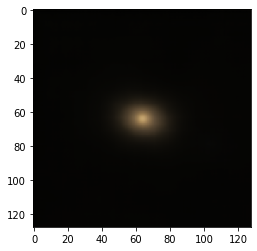

405/405 [==============================] - 366s 902ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.5692 - loss_1: 19.5629 - lr: 5.0000e-04
Epoch 185/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.5701 - loss_1: 19.5791
Epoch 00185: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00185: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00185: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00185: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


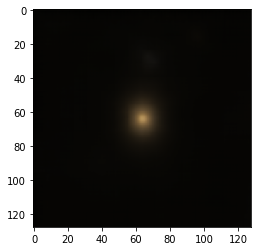

405/405 [==============================] - 366s 902ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.5701 - loss_1: 19.5791 - lr: 5.0000e-04
Epoch 186/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.5327 - loss_1: 19.5378
Epoch 00186: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00186: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00186: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00186: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


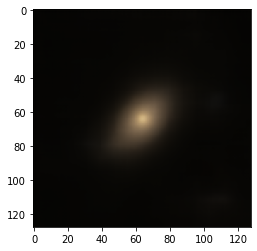

405/405 [==============================] - 365s 901ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.5327 - loss_1: 19.5378 - lr: 5.0000e-04
Epoch 187/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.5701 - loss_1: 19.5751
Epoch 00187: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00187: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00187: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00187: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


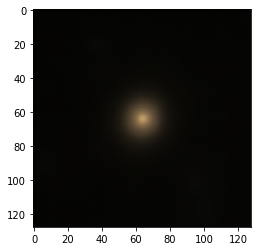

405/405 [==============================] - 366s 903ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.5701 - loss_1: 19.5751 - lr: 5.0000e-04
Epoch 188/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.5954 - loss_1: 19.6023
Epoch 00188: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00188: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00188: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00188: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


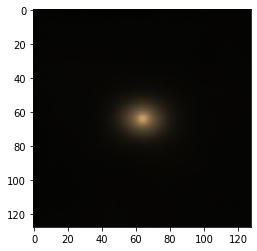

405/405 [==============================] - 366s 904ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.5954 - loss_1: 19.6023 - lr: 5.0000e-04
Epoch 189/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.5782 - loss_1: 19.5795
Epoch 00189: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00189: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00189: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00189: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


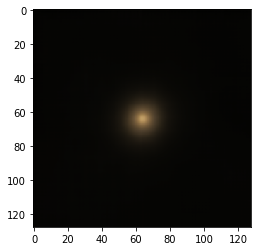

405/405 [==============================] - 366s 903ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.5782 - loss_1: 19.5795 - lr: 5.0000e-04
Epoch 190/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.5911 - loss_1: 19.5831
Epoch 00190: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00190: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00190: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00190: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


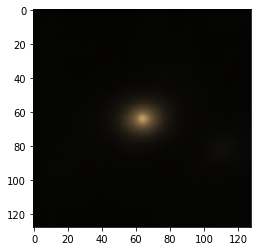

405/405 [==============================] - 366s 902ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.5911 - loss_1: 19.5831 - lr: 5.0000e-04
Epoch 191/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.5622 - loss_1: 19.5525
Epoch 00191: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00191: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00191: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00191: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


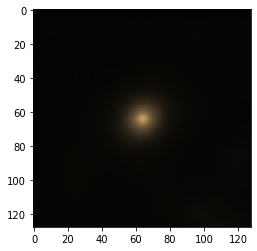

405/405 [==============================] - 372s 917ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.5622 - loss_1: 19.5525 - lr: 5.0000e-04
Epoch 192/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.5423 - loss_1: 19.5483
Epoch 00192: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00192: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00192: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00192: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


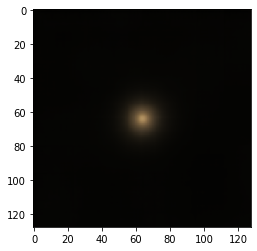

405/405 [==============================] - 372s 917ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.5423 - loss_1: 19.5483 - lr: 5.0000e-04
Epoch 193/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.5564 - loss_1: 19.5609
Epoch 00193: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00193: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00193: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00193: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


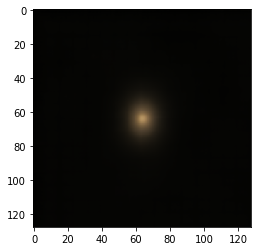

405/405 [==============================] - 368s 907ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.5564 - loss_1: 19.5609 - lr: 5.0000e-04
Epoch 194/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.5486 - loss_1: 19.5460
Epoch 00194: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00194: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00194: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00194: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


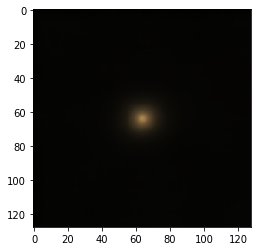

405/405 [==============================] - 366s 904ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.5486 - loss_1: 19.5460 - lr: 5.0000e-04
Epoch 195/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.6127 - loss_1: 19.6175
Epoch 00195: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00195: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00195: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00195: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


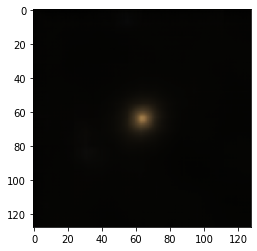

405/405 [==============================] - 365s 901ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.6127 - loss_1: 19.6175 - lr: 5.0000e-04
Epoch 196/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.5733 - loss_1: 19.5561
Epoch 00196: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00196: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00196: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00196: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


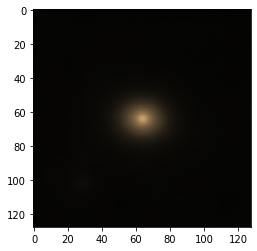

405/405 [==============================] - 366s 903ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.5732 - loss_1: 19.5561 - lr: 5.0000e-04
Epoch 197/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.5529 - loss_1: 19.5408
Epoch 00197: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00197: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00197: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00197: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


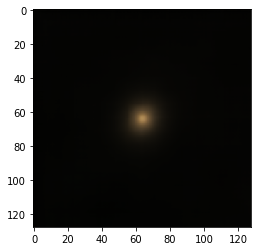

405/405 [==============================] - 366s 904ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.5529 - loss_1: 19.5408 - lr: 5.0000e-04
Epoch 198/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.5383 - loss_1: 19.5409
Epoch 00198: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00198: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00198: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00198: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


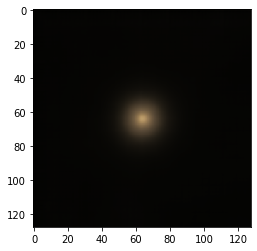

405/405 [==============================] - 370s 913ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.5383 - loss_1: 19.5409 - lr: 5.0000e-04
Epoch 199/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.5255 - loss_1: 19.5259
Epoch 00199: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00199: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00199: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00199: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


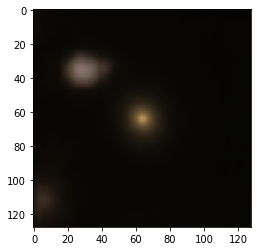

405/405 [==============================] - 367s 905ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.5255 - loss_1: 19.5259 - lr: 5.0000e-04
Epoch 200/200
406/405 [==============================] - ETA: 0s - batch: 202.5000 - size: 31.9483 - loss: 19.5476 - loss_1: 19.5384
Epoch 00200: saving model to /content/google_drive/My Drive/data/galaxy_data/weights.h5

Epoch 00200: saving model to /content/google_drive/My Drive/data/galaxy_data/model.h5

Epoch 00200: saving model to /content/google_drive/My Drive/data/galaxy_data/encoder.h5

Epoch 00200: saving model to /content/google_drive/My Drive/data/galaxy_data/decoder.h5


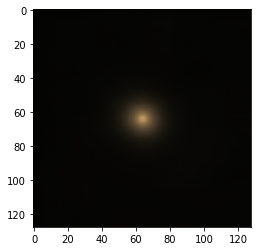

405/405 [==============================] - 367s 906ms/step - batch: 202.5000 - size: 31.9483 - loss: 19.5476 - loss_1: 19.5384 - lr: 5.0000e-04


In [ ]:
# train the VAE with fit_generator
history = VAE.train(   
    save_path = DATA_DIR,
    data_flow = data_flow,
    epochs = EPOCHS,
    steps_per_epoch = DATASET_SIZE / BATCH_SIZE,
    initial_epoch = INITIAL_EPOCH,
    learning_rate = 0.0005
)

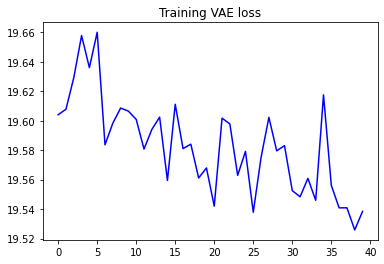

In [ ]:
# plot loss 
plt.figure()
plt.plot(history.history['loss'], 'b')
plt.title("Training VAE loss")
plt.show()

## **Test** 

In [ ]:
# load pretrained weights
VAE.load_trained_weights(DATA_DIR)

In [ ]:
from PIL import Image
import os
import numpy as np

def loadImage(img_path, INPUT_DIMS=(128, 128, 3)):
    pil_image = Image.open(img_path)
    pil_image = pil_image.resize((INPUT_DIMS[0],INPUT_DIMS[1]), Image.ANTIALIAS)
    image = np.array(pil_image)/255.
    return image

### Reconstruct faces

In [ ]:
test_images_100 = os.listdir(TEST_PATH + '/galaxies')[100 : 500]

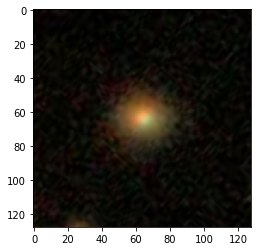

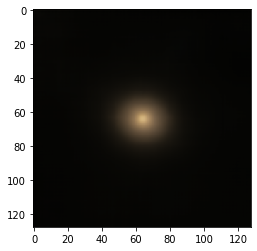

In [ ]:
# Testing
random_id_100 = random.randint(0,399)
test_img_path = os.path.join(TEST_PATH, 'galaxies', test_images_100[random_id_100])
image = loadImage(test_img_path)

latent_space = VAE.encoder.predict(np.expand_dims(image,0))
reconstructed_image = VAE.decoder.predict(latent_space)

plt.figure()
plt.imshow(image)
plt.figure()
plt.imshow(reconstructed_image.squeeze())
plt.show()

### Generate new images

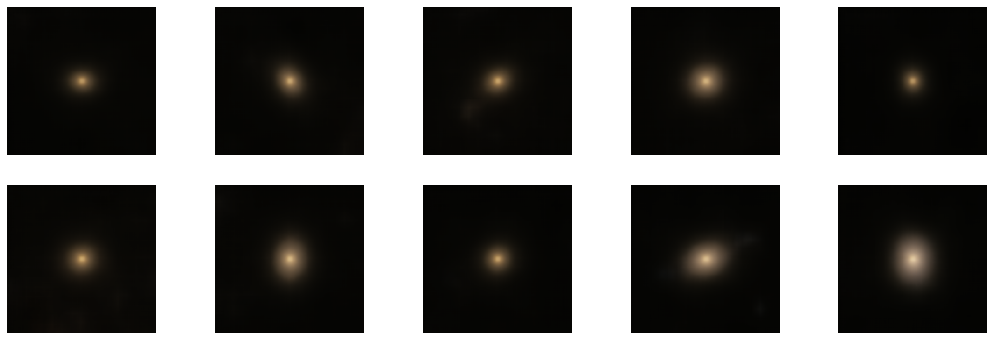

In [ ]:
number_of_images = 10

# sample from normal distribution
latent_space = np.random.normal(size=(number_of_images, LATENT_SPACE_SIZE))

# generate new image from latent space
generated_image = VAE.decoder.predict(latent_space)

# plot the images
fig = plt.figure(figsize=(18,6))
for i in range(number_of_images):
    ax = fig.add_subplot(2, number_of_images/2, i+1)
    ax.imshow(generated_image[i, :,:,:])
    ax.axis('off')
plt.show()

## **Distribution of points in latent space**

### Distributions of separate dimensions in latent space

In [ ]:
in_between_smooth_galaxies = os.path.join(DATA_DIR, 'training', '1_in_between_smooth')
in_between_smooth_galaxies

'/content/google_drive/My Drive/data/galaxy_data/training/1_in_between_smooth'

In [ ]:
% cd /content/google_drive/My Drive/data/galaxy_data/training/
% ls 1_in_between_smooth/ | wc -l

In [ ]:
INPUT_DIMS

(128, 128, 3)

In [ ]:
galaxy_images = os.listdir(in_between_smooth_galaxies)[100 : 200]
galaxy_images[:2]

['454733.jpg', '254614.jpg']

In [ ]:
LATENT_SPACE_SIZE

200

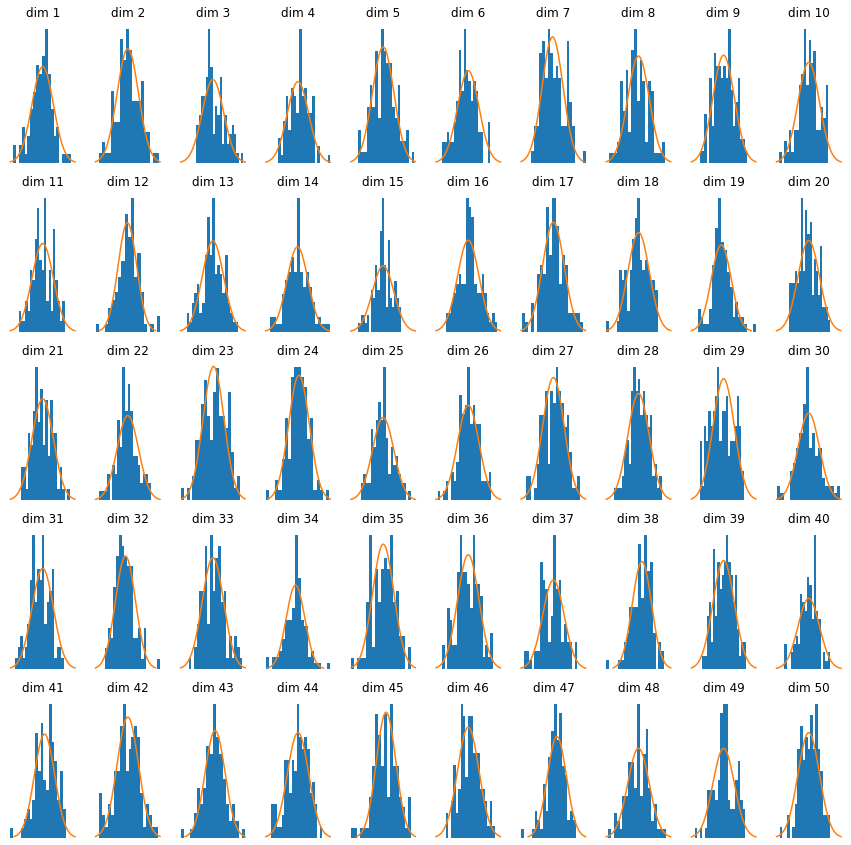

In [ ]:
from scipy.stats import norm

number_of_images = 100 # the more images you choose, the better will be approximation
number_of_dimensions = 50


image = loadImage(test_img_path)

# Load images
images = np.zeros((number_of_images,)+INPUT_DIMS)
for i in range(number_of_images):
  random_id = random.randint(0,99)
  img_path_i = os.path.join(in_between_smooth_galaxies, galaxy_images[random_id])
  images[i,:,:,:] = loadImage(img_path_i)

# get latent space by passing images through encoder
# latent_space.shape = (number_of_images, LATENT_SPACE_SIZE)
latent_space = VAE.encoder.predict(images)

# plot distribution of points in each dimension
fig = plt.figure(figsize=(15, 15))
for i in range(number_of_dimensions):
    ax = fig.add_subplot(number_of_dimensions/10, 10, i+1)
    ax.hist(latent_space[:,i], density=True, bins = 20)
    ax.set_title(loc='center', label='dim {}'.format(i+1))
    x = np.linspace(-3,3,200)
    y = norm.pdf(np.linspace(-3,3,200))
    ax.plot(x, y)
    ax.axis('off')
plt.show()
del images

### Distribution of latent space

Visualising normal distribution of latent space using t-SNE (2D)

In [ ]:
from sklearn.manifold import TSNE
# it takes some time to reduce the dimensions with t-SNE
latent_space_embedded = TSNE(n_components=2).fit_transform(latent_space)

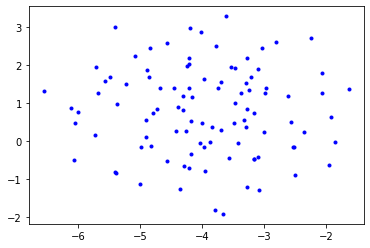

In [ ]:
# plot in 2D
plt.plot(latent_space_embedded[:,0],latent_space_embedded[:,1], 'b.')
plt.show()

Visualising normal distribution of latent space using t-SNE (3D)

In [ ]:
import plotly.graph_objects as go
from plotly.io import write_image
from sklearn.manifold import TSNE

def bin_centers(bins):
    centers = (bins + (bins[1]-bins[0])/2) [:-1]    
    return centers

In [ ]:
x = latent_space_embedded[:,0]
y = latent_space_embedded[:,1]
h, x_edges, y_edges = np.histogram2d(x, y, bins=50, density=True)
x_bins_centers = bin_centers(x_edges)
y_bins_centers = bin_centers(y_edges)
# plot in 3D using plotly

fig = go.Figure(data=[go.Surface(x=x_bins_centers, y=y_bins_centers, z=h)])
fig.show()